# Modeling mental health problems


Author     : Dan Qin  
Date      : 2018/04/23  
Word count  : 2811 words  

### Table of Contents
- [1 -  Introduction](#ch1)
- [2 -  Gather the Data](#ch2) 
- [3 -  Data Handling and Cleaning](#ch3)
    - [3.1 Deal with null values](#ch31)
    - [3.2 Convert data types](#ch32)
    - [3.3 Customary binary coding](#ch33)
    - [3.4 Standardization](#ch34)
    - [3.5 One-Hot Encoding](#ch35)
- [4 - Exploratory Data Analysis](#ch4)
    - [4.1 Relationship to proportion of mental problems](#ch41)
    - [4.2 Relationships between variables](#ch42)
- [5 - Model Data](#ch5)
    - [5.1 Preprocessing](#ch51)
    - [5.2 KMeans Classifier](#ch52)
    - [5.3 Decision Tree Classifier](#ch53)
    - [5.4 Random Forest Classifier](#ch54)
    - [5.5 Support Vector Machine](#ch55)
- [6 - Evaluate Model Performance](#ch6)
    - [6.1 Confusion Matrix](#ch61)
    - [6.2 Classification report](#ch62)
- [7 - Tune model with hyperparameters](#ch7)
- [8 - Conclusion](#ch8)
- [9 - Reference](#ch90)
- [10 - Credits](#ch91)
- [11 - Versions of Libraries](#ch92)
- [12 - Appendix](#ch93)

<font size = 1>*Notice: Please be aware that some of the codes below may take a while to generate.*</font>

<a id="ch1"></a>

## 1. Introduction

Mental health problems are among the most important contributors to disease and disability worldwide. Meanwhile, it has been noted long ago that work-related stress may result in mental health problems. For some occupations, stress can be a huge aspect of the job. While some people can be accustomed to dealing with pressure in specific work circumstances, some people can't. Yet it is widely accepted that certain kinds of jobs are more stressful than others. These jobs may involve life or death decisions, demanding deadlines and competitiveness, etc.

In this paper we will try to look at the relation between occupations and people's mental health conditions and see if we could predict what occupations are more likely to cause mental health problems.

We will take workers in the United Kingdom as our object of study and use machine learning techniques to build our predictive model.

<a id="ch2"></a>

## 2. Gather the Data 

In this analysis, we use data from the UK Labour Force Survey(ONS, 2017 Q1). The Labour Force Survey(LFS) is a study of the employment circumstances of the UK population. It provides detailed information with a wide range of related topics such as occupation, hours of work and household composition etc. It covers the whole of the UK and includes 88,801 samples chosen by simple random sampling. The data is publicly available on UK data service website.

The questionnaire of the survey can be split into two main parts. The first contains questions on the respondent's household, family structure, basic housing information and demographic details of household members. The second part covers topics of economic activity, education and health. In the health section, there is a variable "HEALTH" which records the main health problem of the respondent. We will use this variable to generate our class labels.

As for the predictor variables, we particularly select those which are related to the problem we are concerned with to avoid unnecessary computation and bias. According to what Harnois & Gabriel(2000) pointed out in their book, the stressful characteristics of work include poor organizational function and culture, role conflict, career uncertainty, poor pay and status, job insecurity and redundancy, lack of control over work and pacing, inflexible work schedule and long working hours, etc. 

Based on their theory, we choose the following variables for our modeling:
- Individual demographics: SEX, AGE

- Economic activity: 
    - STAT(employment status)
    - INDE07M(industry sectors in main job)
    - SC10MMJ(major occupation group)
    - TTUSHR(usual hours worked including overtime)
    - SHFTYP(type of shift pattern)
    - GRSSWK(gross weekly pay in main job)

<font size = 1>Variable details please see Appendix. below.</font>

The "LNGLST"(health conditions lasting 12 months or more) and "ILODEFR"(basic economic activity) variables are also useful when filtering our data, therefore we will keep these as well.

Now let's get the data we need. First we retrieve these variables from the LFS data and create a subset for our analysis.

In [2]:
# libraries for dealing with data
import pandas as pd
import numpy as np

In [83]:
# load the LFS data
# this may take a while since the data is large
data_raw = pd.read_csv("data/UK_LabourSurvey_2017Q2.csv", low_memory = False)
data_raw.head()

,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,ACTWKDY6,...,YERQAL2,YERQAL3,YLESS6,YMORE,YPAYL,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
1,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,-9,...,22,-9,-9,-9,-9,-9,-9,-9,-9,-9
2,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,-9,...,21,-9,-9,-9,-9,-9,-9,-9,-9,-9
3,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
4,-9.0,-9.0,-9.0,-9.0,1,2,3,4,5,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9


In [124]:
# create a subset with the variables we need
keys = ["HEALTH", "SEX", "AGE", "STAT", "INDE07M", "SC10MMJ", 
        "TTUSHR", "SHFTYP", "GRSSWK", "ILODEFR","LNGLST"]
data_sub = data_raw[keys]
data_sub.head()

,HEALTH,SEX,AGE,STAT,INDE07M,SC10MMJ,TTUSHR,SHFTYP,GRSSWK,ILODEFR,LNGLST
0,17,2,71,-9,-9,-9,-9,-9,-9,3,1
1,9,2,68,2,-9,-9,-9,-9,-9,3,1
2,2,1,66,-9,-9,-9,-9,-9,-9,3,1
3,-9,2,35,1,-9,-9,-9,-9,-9,3,2
4,-9,1,36,1,8,2,48,-9,-9,1,2


Then, we use the "ILODEFR" and "LNGLST" variables to filter out respondents who are in employment and whose reported health conditions have lasted for over a year.

In [125]:
# filter the data
data_sub = data_sub[data_sub.ILODEFR == 1]
data_sub = data_sub[data_sub.LNGLST == 1]
data_sub.describe()

,HEALTH,SEX,AGE,STAT,INDE07M,SC10MMJ,TTUSHR,SHFTYP,GRSSWK,ILODEFR,LNGLST
count,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.0,11121.0
mean,8.826904,1.504811,46.970686,1.176693,6.218955,4.500045,33.421365,-6.631778,117.348979,1.0,1.0
std,5.169064,0.499999,13.381677,0.549836,2.208833,2.652782,15.929565,5.621941,286.639675,0.0,0.0
min,-8.000000,1.000000,16.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,1.0,1.0
25%,3.000000,1.000000,37.000000,1.000000,5.000000,2.000000,24.000000,-9.000000,-9.000000,1.0,1.0
50%,9.000000,2.000000,49.000000,1.000000,7.000000,4.000000,37.000000,-9.000000,-9.000000,1.0,1.0
75%,12.000000,2.000000,57.000000,1.000000,8.000000,7.000000,42.000000,-9.000000,69.000000,1.0,1.0
max,17.000000,2.000000,91.000000,4.000000,9.000000,9.000000,97.000000,10.000000,3769.000000,1.0,1.0


In [126]:
# save it to local file 
data_sub = data_sub.drop(columns=['ILODEFR', 'LNGLST'])
data_sub.to_csv("data/UK_LFS_2017Q2sub.csv")

Now we have the data. The next step is to clean the data.

<a id="ch3"></a>

## 3. Data Handling and Cleaning


In this stage, we will clean our data by:
1. **Correcting: ** check the validity of the data and correct aberrant values and outliers
2. **Completing:** deal with null values and missing data
3. **Creating:** create new features for later analysis
4. **Converting:** convert data types if necessary

<a id="ch31"></a>
### 3.1 Deal with null values
First, we need to rename the columns so that the table is more readable.

In [205]:
# rename columns
new_keys = ["Health","Sex","Age","EmplyStat","Industry","OccpGroup",
            "WkHours","Shift","Pay"]
data_cp = data_sub.copy()
data_cp.columns = new_keys
data_cp.head()

,Health,Sex,Age,EmplyStat,Industry,OccpGroup,WkHours,Shift,Pay
16,17,2,28,1,8,2,38,10,-9
26,12,1,56,1,5,8,24,-9,190
29,10,1,42,1,3,5,24,-9,-9
39,2,1,50,1,3,8,-8,7,-9
42,-8,2,61,1,5,9,14,-9,-9


Then, let's take a look at the number of null values in each column. Null values in the dataset are recorded as "-8"(no answer) and "-9"(do not apply). 

In [129]:
data_cp.describe()

,Health,Sex,Age,EmplyStat,Industry,OccpGroup,WkHours,Shift,Pay
count,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000,11121.000000
mean,8.826904,1.504811,46.970686,1.176693,6.218955,4.500045,33.421365,-6.631778,117.348979
std,5.169064,0.499999,13.381677,0.549836,2.208833,2.652782,15.929565,5.621941,286.639675
min,-8.000000,1.000000,16.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,3.000000,1.000000,37.000000,1.000000,5.000000,2.000000,24.000000,-9.000000,-9.000000
50%,9.000000,2.000000,49.000000,1.000000,7.000000,4.000000,37.000000,-9.000000,-9.000000
75%,12.000000,2.000000,57.000000,1.000000,8.000000,7.000000,42.000000,-9.000000,69.000000
max,17.000000,2.000000,91.000000,4.000000,9.000000,9.000000,97.000000,10.000000,3769.000000


In [130]:
data_cp.EmplyStat.value_counts()

 1    9170
 2    1859
 4      66
 3      14
-9      12
Name: EmplyStat, dtype: int64

In [131]:
data_cp.Industry.value_counts()

 8    3595
 5    2090
 7    1735
 6     986
 3     931
 9     701
 4     699
 2     181
 1     142
-8      37
-9      24
Name: Industry, dtype: int64

In [132]:
data_cp.OccpGroup.value_counts()

 2    2152
 3    1463
 4    1261
 9    1195
 1    1138
 6    1131
 5    1072
 7     915
 8     765
-9      24
-8       5
Name: OccpGroup, dtype: int64

In [140]:
len(data_cp[(data_cp.WkHours == -9)|(data_cp.WkHours == -8)])

352

In [138]:
data_cp.Shift.value_counts()

-9     9363
 10     520
 3      403
 4      224
 8      164
 1      133
 7      108
 5       66
 6       63
 2       39
 9       31
-8        7
Name: Shift, dtype: int64

In [139]:
len(data_cp[(data_cp.Pay == -9)|(data_cp.Pay == -8)])

8248

The number of missing values vary a great deal between different columns, which indicates that we should use different strategies to deal with them. Some columns like "EmplyStat", "Industry" and "OccpGroup" only have a few null values, so we can consider excluding them from our dataset. We will also exclude null values in "Health" that don't contribute to our analysis.

In [206]:
# exclude null values
# -8 means "no answer", -9 means"do not apply
data_cp = data_cp[data_cp.Health != -8]
data_cp = data_cp[(data_cp.EmplyStat != -8)&(data_cp.EmplyStat != -9)]
data_cp = data_cp[(data_cp.OccpGroup != -8)&(data_cp.OccpGroup != -9)]
data_cp = data_cp[(data_cp.Industry != -8)&(data_cp.Industry != -9)]
data_cp = data_cp[data_cp.Shift != -8]  # keep "-9" values here for later conversion

data_cp.describe()

,Health,Sex,Age,EmplyStat,Industry,OccpGroup,WkHours,Shift,Pay
count,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000
mean,8.966134,1.504610,46.989229,1.187403,6.301232,4.534733,33.552442,-6.631310,118.180192
std,4.946108,0.500002,13.368319,0.435785,1.929560,2.566400,15.750493,5.620539,287.936916
min,1.000000,1.000000,16.000000,1.000000,1.000000,1.000000,-8.000000,-9.000000,-9.000000
25%,3.000000,1.000000,37.000000,1.000000,5.000000,2.000000,24.000000,-9.000000,-9.000000
50%,9.000000,2.000000,49.000000,1.000000,7.000000,4.000000,37.000000,-9.000000,-9.000000
75%,12.000000,2.000000,57.000000,1.000000,8.000000,7.000000,42.000000,-9.000000,74.500000
max,17.000000,2.000000,91.000000,4.000000,9.000000,9.000000,97.000000,10.000000,3769.000000


As for the "Pay" variable, there is a huge amount of missing values, nearly taking 74% of the whole dataset. The "WkHours" column also missed 3% of its values. Considering that these are both important features that may have impacts on our final model, we need to be careful with it instead of simply excluding the data. 

Let's first take a quick look at the distribution of values in these columns.

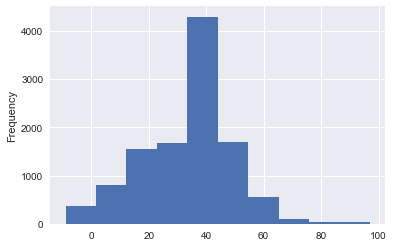

In [142]:
data_cp["WkHours"].plot.hist()

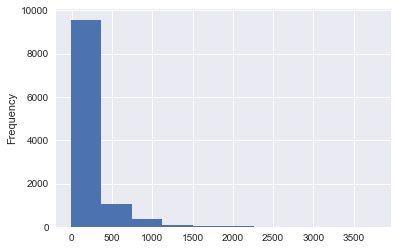

In [143]:
data_cp["Pay"].plot.hist()

The distributions of these variables are in line with what we have learned from experience in real world. The distribution of working hours is close to normal distribution. And the one of pay seem to follow a power law behaviour, with a long tail towards the right end.

This is an indication that the missing values also fit into the existing distribution. Therefore, we assume that we are dealing with data Missing At Random(MAR) and we will use some imputation methods to fix our dataset.

Here we use the  Multiple Imputation by Chained Equations(MICE) method in fancyimpute package to impute the dataset(the doc of the package can be found [here](https://github.com/iskandr/fancyimpute)). 

In [149]:
# import library
from fancyimpute import MICE

In [208]:
# set the null values to NaN
data_cp = data_cp.replace(-9, np.nan)
data_cp = data_cp.replace(-8, np.nan)
data_cp.head()

,Health,Sex,Age,EmplyStat,Industry,OccpGroup,WkHours,Shift,Pay
16,17,2,28,1,8,2,38.0,1,NaN
26,12,1,56,1,5,8,24.0,0,190.0
29,10,1,42,1,3,5,24.0,0,NaN
39,2,1,50,1,3,8,NaN,1,NaN
52,17,1,63,1,7,9,12.0,0,NaN


In [172]:
data_cp.describe()

,Health,Sex,Age,EmplyStat,Industry,OccpGroup,WkHours,Shift,Pay
count,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10643.000000,10955.000000,2842.000000
mean,8.966134,1.504610,46.989229,1.187403,6.301232,4.534733,34.770553,0.157645,481.051724
std,4.946108,0.500002,13.368319,0.435785,1.929560,2.566400,14.256469,0.364424,376.564781
min,1.000000,1.000000,16.000000,1.000000,1.000000,1.000000,0.000000,0.000000,6.000000
25%,3.000000,1.000000,37.000000,1.000000,5.000000,2.000000,25.000000,0.000000,231.000000
50%,9.000000,2.000000,49.000000,1.000000,7.000000,4.000000,37.000000,0.000000,392.000000
75%,12.000000,2.000000,57.000000,1.000000,8.000000,7.000000,42.000000,0.000000,615.000000
max,17.000000,2.000000,91.000000,4.000000,9.000000,9.000000,97.000000,1.000000,3769.000000


In [209]:
# perform MICE
data_imp = MICE(min_value = 0).complete(data_cp.as_matrix())

[MICE] Completing matrix with shape (10955, 9)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.005
[MICE] Starting imputation round 3/110, elapsed time 0.009
[MICE] Starting imputation round 4/110, elapsed time 0.013
[MICE] Starting imputation round 5/110, elapsed time 0.018
[MICE] Starting imputation round 6/110, elapsed time 0.022
[MICE] Starting imputation round 7/110, elapsed time 0.026
[MICE] Starting imputation round 8/110, elapsed time 0.031
[MICE] Starting imputation round 9/110, elapsed time 0.035
[MICE] Starting imputation round 10/110, elapsed time 0.040
[MICE] Starting imputation round 11/110, elapsed time 0.044
[MICE] Starting imputation round 12/110, elapsed time 0.049
[MICE] Starting imputation round 13/110, elapsed time 0.053
[MICE] Starting imputation round 14/110, elapsed time 0.057
[MICE] Starting imputation round 15/110, elapsed time 0.061
[MICE] Starting imputation round 16/110, elapsed time 0.067
[M

In [210]:
# check if all NaN values are imputed
data_imp = pd.DataFrame(data_imp)
assert data_imp.isnull().sum().sum() == 0, 'Not all NAs removed'

In [211]:
# check the dataset after imputation
data_imp.columns = data_cp.columns
data_imp.describe()

,Health,Sex,Age,EmplyStat,Industry,OccpGroup,WkHours,Shift,Pay
count,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000
mean,8.966134,1.504610,46.989229,1.187403,6.301232,4.534733,34.775334,0.157645,494.137924
std,4.946108,0.500002,13.368319,0.435785,1.929560,2.566400,14.066545,0.364424,264.089668
min,1.000000,1.000000,16.000000,1.000000,1.000000,1.000000,0.000000,0.000000,6.000000
25%,3.000000,1.000000,37.000000,1.000000,5.000000,2.000000,25.000000,0.000000,315.270187
50%,9.000000,2.000000,49.000000,1.000000,7.000000,4.000000,37.000000,0.000000,481.000000
75%,12.000000,2.000000,57.000000,1.000000,8.000000,7.000000,42.000000,0.000000,623.000000
max,17.000000,2.000000,91.000000,4.000000,9.000000,9.000000,97.000000,1.000000,3769.000000


Now we will take a look at the distribution of the imputed dataset.

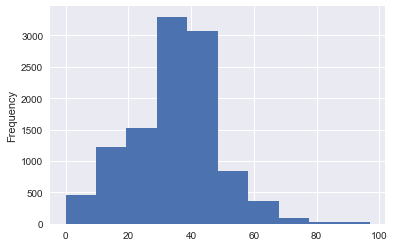

In [176]:
# check the distribution of the imputed data
data_imp["WkHours"].plot.hist()

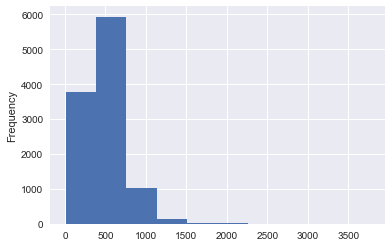

In [177]:
data_imp["Pay"].plot.hist()

The distributions are affected slightly but still follows the same pattern. So we will stay with it.

<a id="ch32"></a>
### 3.2 Convert data types

Now we are left with 10,955 samples in total, which is still good. And then we should check the data types and see if anything goes wrong.

In [193]:
data_imp.dtypes

Health       float64
Sex          float64
Age          float64
EmplyStat    float64
Industry     float64
OccpGroup    float64
WkHours      float64
Shift        float64
Pay          float64
dtype: object

There are some problems with the data types after imputation. Apart from the "Pay" and "WkHours" variable, the data types of the other columns should be "int" instead. So we need to fix it.

In [214]:
data_imp["Health"] = data_imp["Health"].astype("int")
data_imp["Sex"] = data_imp["Sex"].astype("int")
data_imp["Age"] = data_imp["Age"].astype("int")
data_imp["EmplyStat"] = data_imp["EmplyStat"].astype("int")
data_imp["Industry"] = data_imp["Industry"].astype("int")
data_imp["OccpGroup"] = data_imp["OccpGroup"].astype("int")
data_imp["Shift"] = data_imp["Shift"].astype("int")

data_imp.dtypes

Health         int32
Sex            int32
Age            int32
EmplyStat      int32
Industry       int32
OccpGroup      int32
WkHours      float64
Shift          int32
Pay          float64
dtype: object

<a id="ch33"></a>
### 3.3 Customary binary coding


Next, we need to think about whether the values in each column are exactly what we need for our analysis.

The "Shift" variable records various shift working patterns of the respondent and the "-9" value actually means no shift working. Since we are only interested in whether the respondent does shift working or not, we will convert the column values into "0/1" only.

In [207]:
# replace "Shift" values
for i in range(len(data_imp.index)):
    if data_cp.iloc[i,data_imp.columns.get_loc('Shift')] == -9:
        data_cp.iat[i,data_imp.columns.get_loc('Shift')] = 0
    else:
        data_cp.iat[i,data_imp.columns.get_loc('Shift')] = 1

In [146]:
data_imp.Shift.value_counts()

0    9228
1    1727
Name: Shift, dtype: int64

And we will do the same with "Sex" column by converting the "1/2" values into "0/1" values so that the columns stay in consistency.

In [28]:
for i in range(len(data_imp.index)):
    if data_imp.iloc[i,data_imp.columns.get_loc('Sex')] == 1:
        data_imp.iat[i,data_imp.columns.get_loc('Sex')] = 0
    else:
        data_imp.iat[i,data_imp.columns.get_loc('Sex')] = 1

data_imp.Sex.value_counts()

1    5528
0    5427
Name: Sex, dtype: int64

Finally, our target variable "Health" returns a number ranging from 1-17 corresponding to various health problems. However we only worry about whether the respondent suffers a mental health problem or not, so we will transform the column into "0/1" values.

In [215]:
# replace "Health" values
for i in range(len(data_imp.index)):
    if data_imp.iloc[i,0] == 12:
        data_imp.iat[i,0] = 1
    else:
        data_imp.iat[i,0] = 0

In [216]:
# give it a proper name
data_imp.rename(columns = {"Health":"MentalProb"}, inplace = True)
data_imp.MentalProb.value_counts()

0    9816
1    1139
Name: MentalProb, dtype: int64

<a id="ch34"></a>
### 3.4 Standardization
Now inspecting the data again, it seems that the scales of "Age","WkHours" and "Pay" columns are a bit far away from the other variables. This could lead to bias in later modeling. Therefore, we consider doing a standardization to bring the scales down. We will use Z-score scaling in this case to avoid the effect of outliers.

In [30]:
col_index = [data_imp.columns.get_loc("Age"),data_imp.columns.get_loc("WkHours"),data_imp.columns.get_loc("Pay"),]
data_temp = data_imp.copy()

for i in col_index:
    for j in range(len(data_imp.index)) :
        temp_z = (data_temp.iloc[j,i] - data_temp.iloc[:,i].mean())/data_temp.iloc[:,i].std()
        data_imp.iat[j,i] = temp_z
        
data_imp.describe()

,MentalProb,Sex,Age,EmplyStat,Industry,OccpGroup,WkHours,Shift,Pay
count,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,10955.000000,1.095500e+04,10955.000000,1.095500e+04
mean,0.103971,0.504610,-0.046919,1.187403,6.301232,4.534733,-1.738252e-16,0.157645,5.188810e-17
std,0.305237,0.500002,0.670316,0.435785,1.929560,2.566400,1.000000e+00,0.364424,1.000000e+00
min,0.000000,0.000000,-2.000000,1.000000,1.000000,1.000000,-2.472202e+00,0.000000,-1.848379e+00
25%,0.000000,0.000000,0.000000,1.000000,5.000000,2.000000,-6.949350e-01,0.000000,-6.772993e-01
50%,0.000000,1.000000,0.000000,1.000000,7.000000,4.000000,1.581529e-01,0.000000,-4.974797e-02
75%,0.000000,1.000000,0.000000,1.000000,8.000000,7.000000,5.136063e-01,0.000000,4.879482e-01
max,1.000000,1.000000,3.000000,4.000000,9.000000,9.000000,4.423593e+00,1.000000,1.240057e+01


In [32]:
# save the cleaned dataset to local file
data_imp.to_csv("data/UK_LFS_2017Q2clean.csv")

<a id="ch35"></a>
### 3.5 One-Hot Encoding

The categorical features are coded as natural numerical values in the original LFS data, and it would be better if we convert them into "0/1" values using one-hot encoding. This has the benefit of not weighting a value improperly in later modeling, though it will add more columns to our data set.

In [5]:
# perform one-hot encoding
data_dummy = pd.get_dummies(data_imp, columns=["EmplyStat","Industry","OccpGroup"],
                           prefix=["Eply","Industry","Occp"])
data_dummy.head()

,MentalProb,Sex,Age,WkHours,Shift,Pay,Eply_1,Eply_2,Eply_3,Eply_4,...,Industry_9,Occp_1,Occp_2,Occp_3,Occp_4,Occp_5,Occp_6,Occp_7,Occp_8,Occp_9
0,0,1,-1,0.229244,1,0.115827,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,-0.766026,0,-1.151646,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,-0.766026,0,-0.778127,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,-0.250619,1,-0.560722,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,-1.619114,0,-1.235034,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now that the data is cleaned and ready, we will explore the data with some descriptive and graphical statistics to discover its main characteristics.

<a id="ch4"></a>

## 4. Exploratory Data Analysis
<a id="ch41"></a>
### 4.1 Relationship to proportion of mental problems

Before going onto formal modeling, we would like to perform a primarily exploratory data analysis to see what the data can tell us.

First we will look at the correlation of each feature variable to the proportion of people with mental health problems.

In [19]:
# import visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_style('white')
mpl.rcParams.update({'font.size': 15})
%matplotlib inline 

c:\users\eathg\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


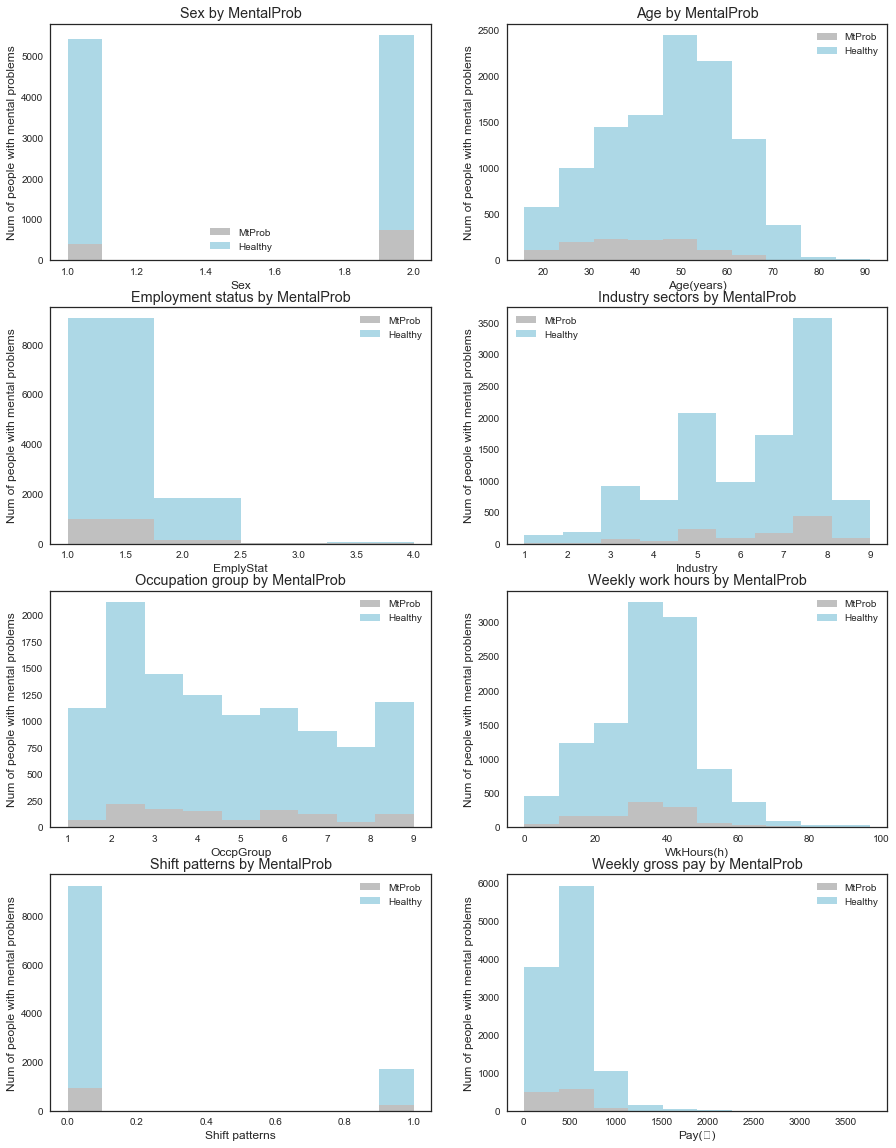

In [229]:
# plot the histograms of each feature variable and the mentalprob variable
plt.figure(figsize=[15,20])

plt.subplot(4,2,1)
plt.hist(x = [data_imp[data_imp.MentalProb==1]['Sex'],data_imp[data_imp.MentalProb==0]['Sex']], 
         stacked = True, color = ['silver','lightblue'], label=['MtProb','Healthy'])
plt.title('Sex by MentalProb')
plt.xlabel('Sex')
plt.ylabel('Number of people')
plt.legend()

plt.subplot(4,2,2)
plt.hist(x = [data_imp[data_imp.MentalProb==1]['Age'],data_imp[data_imp.MentalProb==0]['Age']], 
         stacked = True, color = ['silver','lightblue'], label=['MtProb','Healthy'])
plt.title('Age by MentalProb')
plt.xlabel('Age(years)')
plt.ylabel('Number of people')
plt.legend()

plt.subplot(4,2,3)
plt.hist(x = [data_imp[data_imp.MentalProb==1]['EmplyStat'],data_imp[data_imp.MentalProb==0]['EmplyStat']], 
         stacked = True, color = ['silver','lightblue'], label=['MtProb','Healthy'], bins=4)
plt.title('Employment status by MentalProb')
plt.xlabel('EmplyStat')
plt.ylabel('Number of people')
plt.legend()

plt.subplot(4,2,4)
plt.hist(x = [data_imp[data_imp.MentalProb==1]['Industry'],data_imp[data_imp.MentalProb==0]['Industry']], 
         stacked = True, color = ['silver','lightblue'], label=['MtProb','Healthy'], bins=9)
plt.title('Industry sectors by MentalProb')
plt.xlabel('Industry')
plt.ylabel('Number of people')
plt.legend()

plt.subplot(4,2,5)
plt.hist(x = [data_imp[data_imp.MentalProb==1]['OccpGroup'],data_imp[data_imp.MentalProb==0]['OccpGroup']], 
         stacked = True, color = ['silver','lightblue'], label=['MtProb','Healthy'], bins = 9)
plt.title('Occupation group by MentalProb')
plt.xlabel('OccpGroup')
plt.ylabel('Number of people')
plt.legend()


plt.subplot(4,2,6)
plt.hist(x = [data_imp[data_imp.MentalProb==1]['WkHours'],data_imp[data_imp.MentalProb==0]['WkHours']], 
         stacked = True, color = ['silver','lightblue'], label=['MtProb','Healthy'])
plt.title('Weekly work hours by MentalProb')
plt.xlabel('WkHours(h)')
plt.ylabel('Number of people')
plt.legend()


plt.subplot(4,2,7)
plt.hist(x = [data_imp[data_imp.MentalProb==1]['Shift'],data_imp[data_imp.MentalProb==0]['Shift']], 
         stacked = True, color = ['silver','lightblue'], label=['MtProb','Healthy'])
plt.title('Shift working by MentalProb')
plt.xlabel('Shift working')
plt.ylabel('Number of people')
plt.legend()

plt.subplot(4,2,8)
plt.hist(x = [data_imp[data_imp.MentalProb==1]['Pay'],data_imp[data_imp.MentalProb==0]['Pay']], 
         stacked = True, color = ['silver','lightblue'], label=['MtProb','Healthy'])
plt.title('Weekly gross pay by MentalProb')
plt.xlabel('Pay(￡)')
plt.ylabel('Number of people')
plt.legend()


In [231]:
# Discrete variable correlation by mental health problems
for x in data_imp.columns[1:]:
    if len(data_imp[x].value_counts()) < 12:
        print('MentalPro Correlation by:', x)
        print(data_imp[[x, 'MentalProb']].groupby(x, as_index=False).mean())
        print('-'*30, '\n')
    

MentalPro Correlation by: Sex
   Sex  MentalProb
0    1    0.072600
1    2    0.134768
---------- 

MentalPro Correlation by: EmplyStat
   EmplyStat  MentalProb
0          1    0.110362
1          2    0.072440
2          3    0.181818
3          4    0.092308
---------- 

MentalPro Correlation by: Industry
   Industry  MentalProb
0         1    0.014184
1         2    0.049724
2         3    0.070729
3         4    0.067723
4         5    0.112724
5         6    0.085655
6         7    0.095874
7         8    0.124405
8         9    0.131124
---------- 

MentalPro Correlation by: OccpGroup
   OccpGroup  MentalProb
0          1    0.056889
1          2    0.104991
2          3    0.119889
3          4    0.121285
4          5    0.064090
5          6    0.144643
6          7    0.138274
7          8    0.061008
8          9    0.107718
---------- 

MentalPro Correlation by: Shift
   Shift  MentalProb
0      0    0.099588
1      1    0.127389
---------- 



According to the histograms and correlation table, it seems that females are more likely to feel pressure in work compared to males. The proportion of people suffering mental health problems is higher in younger age groups, and drops as the age accumulates. As for the employment status, people working in government schemes tend to be slightly more stressed than employees, self-employed workers and family workers, with a proportion of 18% of people reporting that they feel depressed.

Occupations in agriculture, forestry, fishing, energy and water industries are among the least stressful in comparison with other sectors, only with a ratio one-tenth of that in public administration, education and health.

People working in higher levels of the management structure, such as managers, directors and senior officials are less likely to feel pressure. While service occupations like caring and leisure cause more depression, with a proportion of nearly 14.5% of people reporting that they are influenced by mental health problems.

Shift-working also has a slight impact on people's mental health, with 3% variance in the ratio between people doing and not doing shift-working .

<a id="ch42"></a>
### 4.2 Relationships between variables

Next, we will look at the correlation between all variables to check if there is redundant information. 

#### 4.2.1 Pair plots

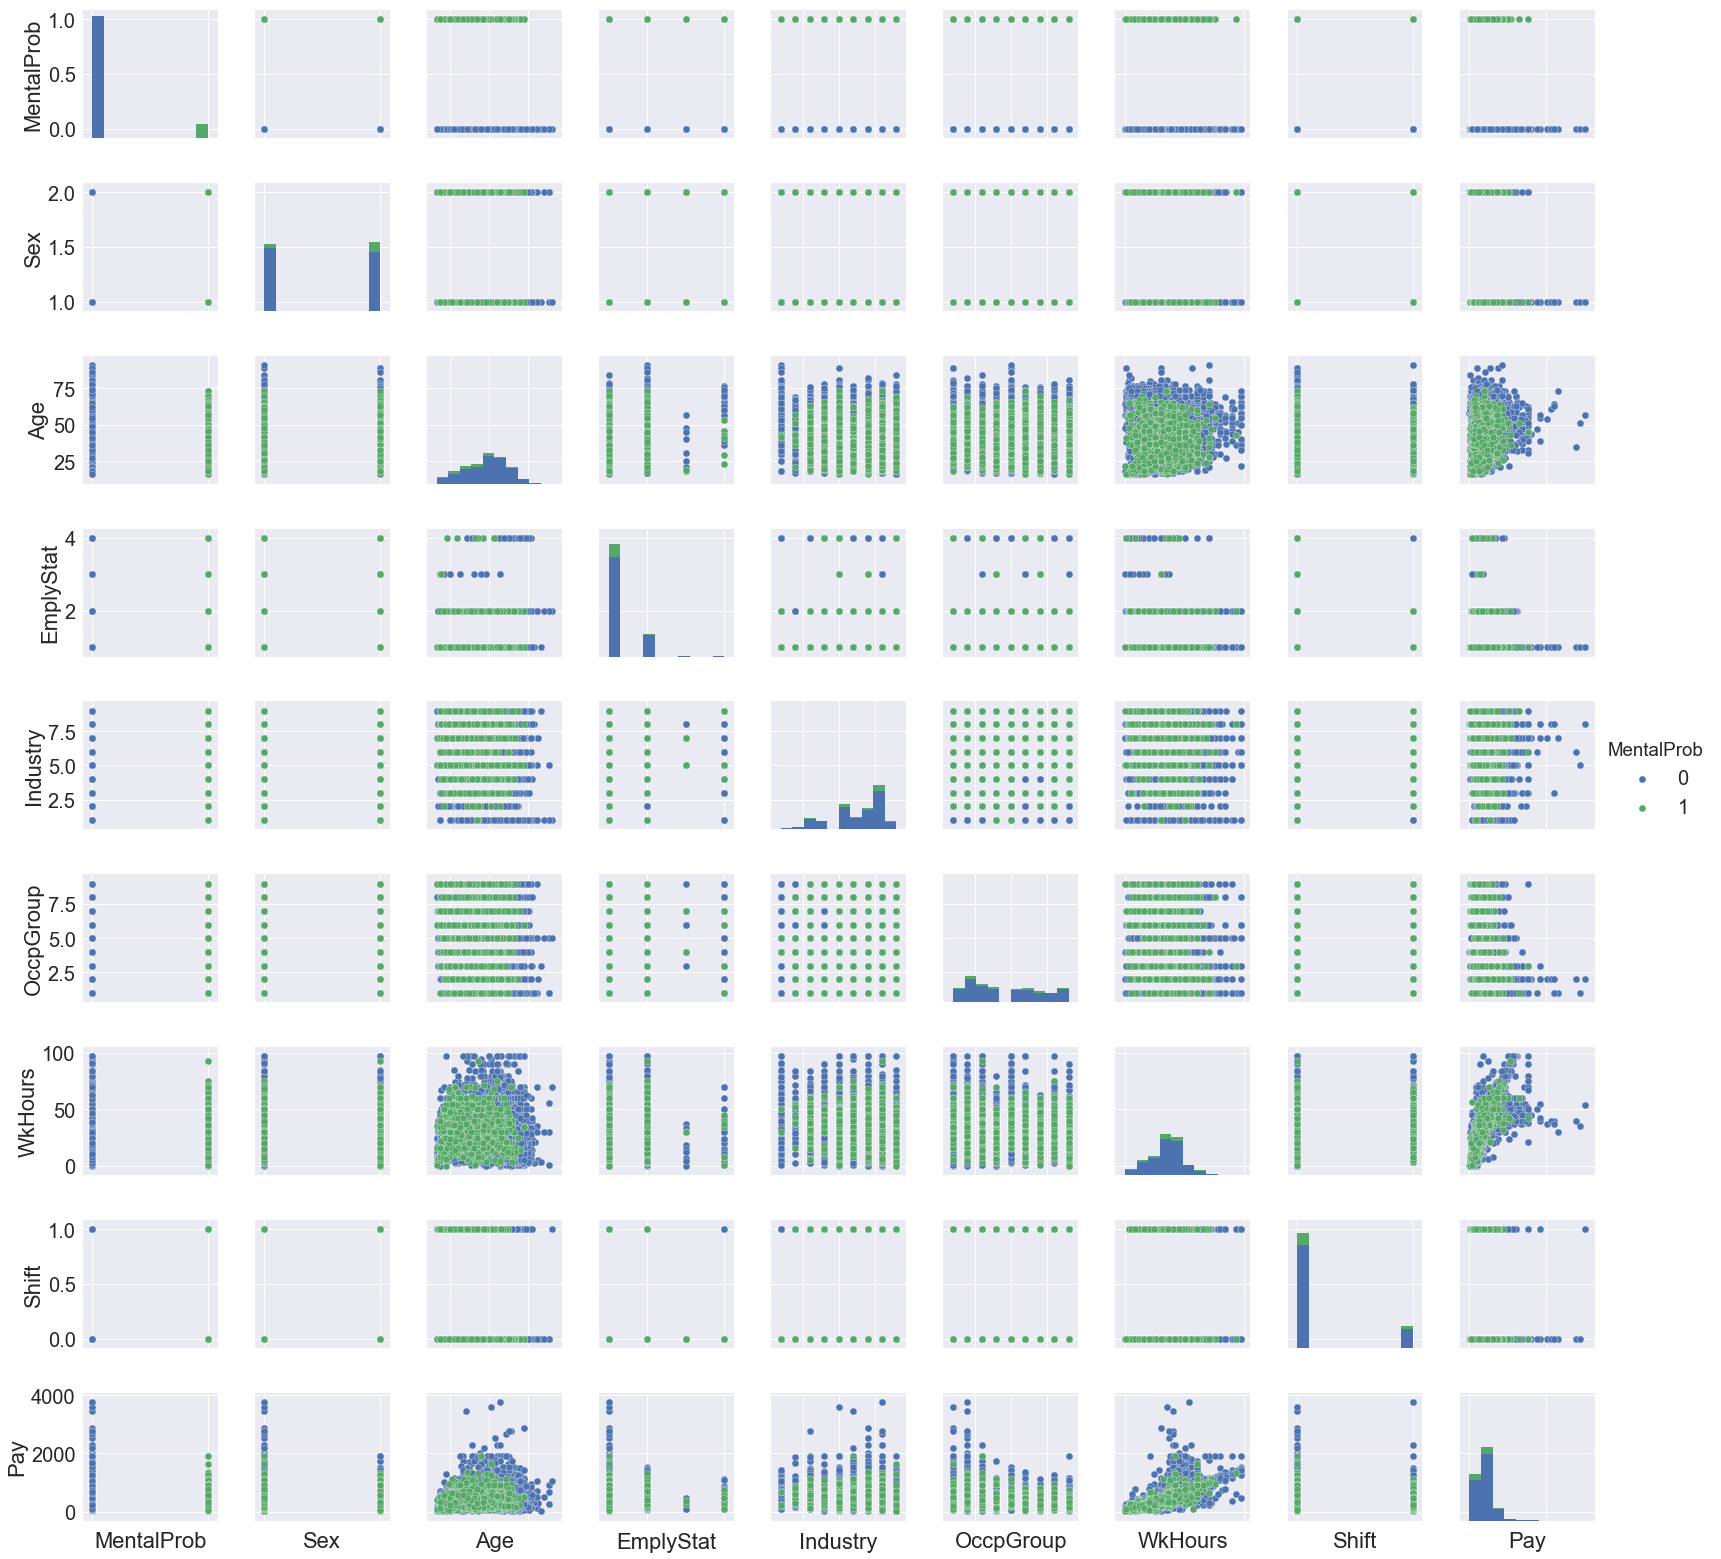

In [232]:
# pair plots of entire dataset(this may take a while)
sns.set(font_scale=2.0)
pp = sns.pairplot(data_imp, hue = 'MentalProb')
pp.set(xticklabels = [])

#### 4.2.2 Correlation matrix

In [233]:
corr = data_imp.corr()
corr

,MentalProb,Sex,Age,EmplyStat,Industry,OccpGroup,WkHours,Shift,Pay
MentalProb,1.000000,0.101837,-0.184254,-0.040116,0.064309,0.019338,-0.040859,0.033191,-0.075115
Sex,0.101837,1.000000,-0.106646,-0.117716,0.304004,-0.005549,-0.305006,-0.027286,-0.295503
Age,-0.184254,-0.106646,1.000000,0.193765,-0.017899,-0.052326,-0.074013,-0.076593,0.103201
EmplyStat,-0.040116,-0.117716,0.193765,1.000000,-0.068227,-0.069938,-0.039097,-0.118788,0.033233
Industry,0.064309,0.304004,-0.017899,-0.068227,1.000000,-0.173559,-0.141684,-0.002366,-0.072128
OccpGroup,0.019338,-0.005549,-0.052326,-0.069938,-0.173559,1.000000,-0.216628,0.160424,-0.478594
WkHours,-0.040859,-0.305006,-0.074013,-0.039097,-0.141684,-0.216628,1.000000,0.064660,0.744562
Shift,0.033191,-0.027286,-0.076593,-0.118788,-0.002366,0.160424,0.064660,1.000000,-0.043353
Pay,-0.075115,-0.295503,0.103201,0.033233,-0.072128,-0.478594,0.744562,-0.043353,1.000000


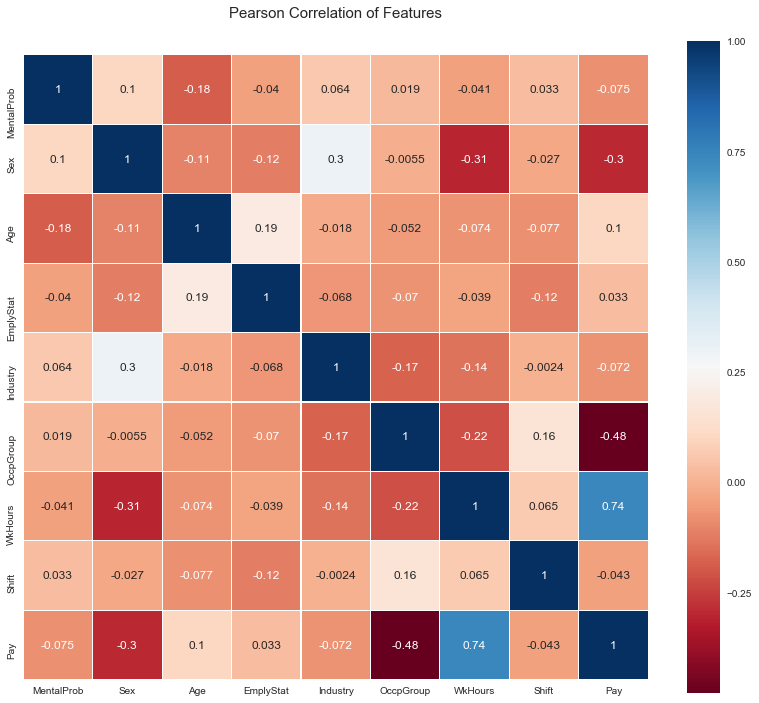

In [234]:
# correlation heat map
sns.set(font_scale=1.0)
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_imp.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

There are not too many features strongly correlated with one another according to the Pearson correlation plot, therefore we can carry on to the next stage of our analysis.

<a id="ch5"></a>

## 5. Model Data

In this section, we will try to build our predictive models with machine learning algorithms. Particularly, we will be testing with various classifiers and see which one gives the best performance. The models we will be using are listed as follows:

1. KMeans Classifier
2. Decision Tree Classifier
2. Random Forest Classifier
3. Support Vector Machine

Before modelling, we should first import the libraries we need and do some preprocessing of the data.

In [4]:
# import machine learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

c:\users\eathg\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<a id="ch51"></a>
### 5.1 Preprocessing

In the preprocessing, we build labels using the "MentalProb" variable for later modeling and use the Principal Components Analysis(PCA) method to reduce the complexity of our dataset.

In [6]:
# split the feature values and label variable
data_value = data_dummy.copy()
data_value = data_value.drop(columns = 'MentalProb')
data_value.head()

,Sex,Age,WkHours,Shift,Pay,Eply_1,Eply_2,Eply_3,Eply_4,Industry_1,...,Industry_9,Occp_1,Occp_2,Occp_3,Occp_4,Occp_5,Occp_6,Occp_7,Occp_8,Occp_9
0,1,-1,0.229244,1,0.115827,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,-0.766026,0,-1.151646,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,-0.766026,0,-0.778127,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,-0.250619,1,-0.560722,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,-1.619114,0,-1.235034,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# create labels
le = LabelEncoder()
labels_fea = le.fit_transform(data_dummy['MentalProb'])

In [239]:
# convert dataframe to array, 
# data_dict = data_value.to_dict('records')
# vec = DictVectorizer()
# vec_data = vec.fit_transform(data_dict)
# vec_array = vec_data.toarray() 

In [8]:
from sklearn.decomposition import PCA
at_mat = data_value.as_matrix()
pca = PCA()
at_decomp = pca.fit_transform(at_mat)

In [35]:
pca.explained_variance_ratio_

array([3.76128740e-01, 1.07566735e-01, 8.10543131e-02, 5.55931678e-02,
       4.93075284e-02, 4.13351058e-02, 3.57587469e-02, 3.10617511e-02,
       2.71595781e-02, 2.50290801e-02, 2.28859757e-02, 2.14418335e-02,
       2.00643442e-02, 1.95469519e-02, 1.66699419e-02, 1.47935577e-02,
       1.36025986e-02, 1.17924147e-02, 1.08092587e-02, 9.68935285e-03,
       3.89836545e-03, 2.72022398e-03, 1.82043521e-03, 2.69999375e-04,
       1.33384301e-32, 8.14331609e-33, 3.74867248e-33])

In [36]:
pca.explained_variance_

array([1.80981153e+00, 5.17576819e-01, 3.90007502e-01, 2.67496592e-01,
       2.37252100e-01, 1.98891345e-01, 1.72059685e-01, 1.49459239e-01,
       1.30683227e-01, 1.20431950e-01, 1.10120015e-01, 1.03171264e-01,
       9.65432247e-02, 9.40536978e-02, 8.02104434e-02, 7.11818810e-02,
       6.54513659e-02, 5.67413385e-02, 5.20107050e-02, 4.66220755e-02,
       1.87576912e-02, 1.30888502e-02, 8.75935361e-03, 1.29915088e-03,
       6.41802713e-32, 3.91830397e-32, 1.80374163e-32])

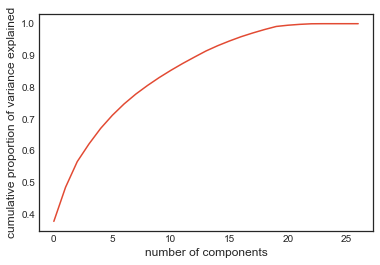

In [41]:
# plot cumulative sum of variance ratio
temp_pca = np.cumsum(pca.explained_variance_ratio_)
plt.xlabel("number of components")
plt.ylabel("cumulative proportion of variance explained")
plt.plot(temp_pca)
plt.show()

The cumulative sum of variance ratio plot shows that around 18 components explain about 98% variance in the data set. And beyond that little variance is gained by retaining additional eigenvalues. Therefore, we will keep the first 18 components as our predictor variables.

In [10]:
# keep only first 18 major components that explains 99% of the data
pca = PCA(n_components = 18)
df_PCA = pca.fit_transform(at_mat)

And then we split our dataset into training and testing dataset. This is to ensure that our model won't be overfitting. The ratio of training and testing dataset we choose is "80/20".

In [11]:
# split the dataset
train_d, test_d, train_lab, test_lab = train_test_split(df_PCA, labels_fea,
                                                        test_size = 0.2)

# check the proportion of MentalProb = 1 in original, training and testing data
# this is to ensure there is not much bias in the training and testing dataset
print("MentalProb proportion in original data:",labels_fea.mean())
print("MentalProb proportion in training data:",train_lab.mean())
print("MentalProb proportion in testing data:",test_lab.mean())

MentalProb proportion in original data: 0.10397078959379279
MentalProb proportion in training data: 0.10554541305340027
MentalProb proportion in testing data: 0.09767229575536285


Before building our models, we shoud first determine if the model is even worth keeping, therefore we need a baseline accuracy for our model. According to the output above, the proportion of reports concerning mental health problems is about 10.18% in the testing dataset. Hence, if we just predict the most frequent occurrence, that 100% of people don't have mental health problems, we would still get an accuracy of 89.82%. So we should set our baseline at 89.82% and if the model's accuracy is lower than the baseline, we should probably reject the model.

<a id="ch52"></a>
### 5.2 KMeans Classifier

In [44]:
# creates the kNN classifier, setting it to check the 60 neighbouring points
knn = KNeighborsClassifier(n_neighbors=60)  
knn.fit(train_d, train_lab)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=60, p=2,
           weights='uniform')

In [45]:
knn.score(test_d, test_lab)

0.8982199908717481

In [46]:
predictions_knn = knn.predict(test_d)

<a id="ch53"></a>
### 5.3 Decision Tree Classifier

In [47]:
dt = DecisionTreeClassifier()
dt.fit(train_d, train_lab)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
dt.score(test_d, test_lab)

0.8096759470561388

In [49]:
predictions_dt = dt.predict(test_d)

<a id="ch54"></a>
### 5.4 Random Forest Classifier

In [50]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(train_d, train_lab)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [51]:
rfc.score(test_d, test_lab)

0.8795070743952533

In [52]:
predictions_rfc = rfc.predict(test_d)

<a id="ch55"></a>
### 5.5 Support Vector Machine

In [53]:
svmc = SVC()
svmc.fit(train_d, train_lab)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
svmc.score(test_d, test_lab)

0.8982199908717481

In [55]:
predictions_svmc = rfc.predict(test_d)

<a id="ch6"></a>

## 6.  Evaluate Model Performance

Now we have trained our models with the training data, we should evaluate how well their performance is. This is done by plotting the confusion matrix and printing classification report.
<a id="ch61"></a>
### 6.1 Confusion Matrix

<Figure size 432x288 with 0 Axes>

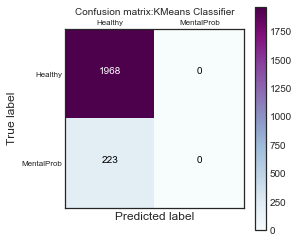

<Figure size 432x288 with 0 Axes>

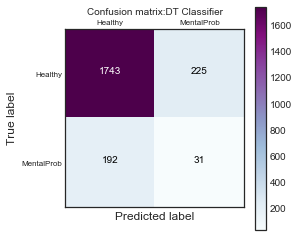

<Figure size 432x288 with 0 Axes>

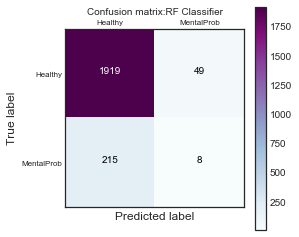

<Figure size 432x288 with 0 Axes>

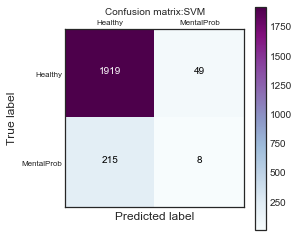

In [56]:
from sklearn import metrics
mpl.rcParams.update({'font.size': 10})

def plt_confusion_matrix(predict,tab,classes,title):
    cm = metrics.confusion_matrix(tab, predict)
        
    plt.matshow(cm,cmap='BuPu')
    plt.title("Confusion matrix:"+ title,fontsize=10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=8)
    plt.yticks(tick_marks, classes,fontsize=8)
    
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# plot the confusion matrix of each classifier
class_n = ["Healthy","MentalProb"]
plt.figure()
plt_confusion_matrix(predictions_knn, test_lab, class_n, title='KMeans Classifier')

plt.figure()
plt_confusion_matrix(predictions_dt, test_lab, class_n, title='DT Classifier')

plt.figure()
plt_confusion_matrix(predictions_rfc, test_lab, class_n, title='RF Classifier')

plt.figure()
plt_confusion_matrix(predictions_svmc, test_lab, class_n, title='SVM')

<a id="ch62"></a>
### 6.2 Classification report

In [57]:
print('Knn model classification report:')
print (metrics.classification_report(test_lab, predictions_knn))
print('-'*52, '\n')

print('DT model classification report:')
print (metrics.classification_report(test_lab, predictions_dt))
print('-'*52, '\n')

print('RFC model classification report:')
print (metrics.classification_report(test_lab, predictions_rfc))
print('-'*52, '\n')

print('SVM model classification report:')
print (metrics.classification_report(test_lab, predictions_svmc))
print('-'*52, '\n')

Knn model classification report:
             precision    recall  f1-score   support

          0       0.90      1.00      0.95      1968
          1       0.00      0.00      0.00       223

avg / total       0.81      0.90      0.85      2191

---------------------------------------------------- 

DT model classification report:
             precision    recall  f1-score   support

          0       0.90      0.89      0.89      1968
          1       0.12      0.14      0.13       223

avg / total       0.82      0.81      0.82      2191

---------------------------------------------------- 

RFC model classification report:
             precision    recall  f1-score   support

          0       0.90      0.98      0.94      1968
          1       0.14      0.04      0.06       223

avg / total       0.82      0.88      0.85      2191

---------------------------------------------------- 

SVM model classification report:
             precision    recall  f1-score   support

     

c:\users\eathg\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The results of the models' performance seem to be disappointing. None of the models' accuracy go over our baseline. Before coming to a conclusion on that, let's try tuning the model with hyperparameters and see if things get better.

<a id="ch7"></a>

## 7.  Tune model with hyperparameters
The RandomForest model and the SVM model seems to have higher precision while the DecisionTree model labels the most cases that have mental health problems. Since the SVM model takes a long time to run and it performs no better than the RFC one, we will try tuning the RFC model here.

In [74]:
# use GridSearch to tune the rfc model with hyperparameters
from sklearn.grid_search import GridSearchCV

params = {'n_estimators':[10,100,200],
          'min_samples_split':[2,10]}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, params, cv=5, scoring='accuracy')
grid_search.fit(train_d,train_lab)

# check result
grid_search.grid_scores_

[mean: 0.87677, std: 0.00427, params: {'min_samples_split': 2, 'n_estimators': 10},
 mean: 0.87745, std: 0.00467, params: {'min_samples_split': 2, 'n_estimators': 100},
 mean: 0.87882, std: 0.00447, params: {'min_samples_split': 2, 'n_estimators': 200},
 mean: 0.88487, std: 0.00487, params: {'min_samples_split': 10, 'n_estimators': 10},
 mean: 0.89080, std: 0.00139, params: {'min_samples_split': 10, 'n_estimators': 100},
 mean: 0.89092, std: 0.00284, params: {'min_samples_split': 10, 'n_estimators': 200}]

<Figure size 432x288 with 0 Axes>

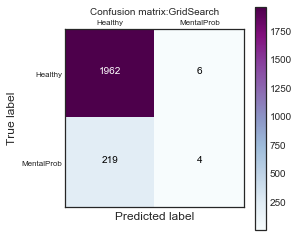

In [75]:
# predict the test data and plot confusion matrix
test_pred = grid_search.predict(test_d)

plt.figure()
plt_confusion_matrix(test_pred, test_lab, class_n, title='GridSearch')

After tuning the model with hyperparameters, the accuracy of the model doesn't improve much. Let's plot the learning curve to see what could be wrong with our data.

In [33]:
# plot learning curve
from sklearn.model_selection import learning_curve

def plot_curve(classifier,train_d, train_lab, title):

    train_sizes, train_scores, test_scores = learning_curve(classifier, train_d, train_lab, train_sizes=[200,400,600,800,1000], cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("LearningCurves of "+title)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()

    # box-like grid
    plt.grid()

    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.legend(loc="best")
    plt.show()

No handles with labels found to put in legend.


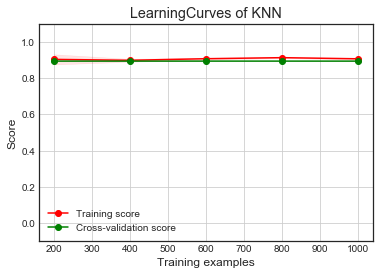

No handles with labels found to put in legend.


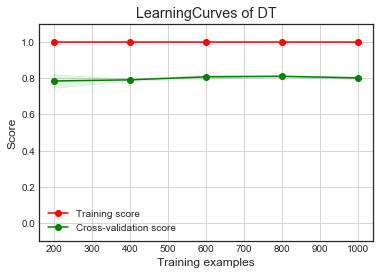

No handles with labels found to put in legend.


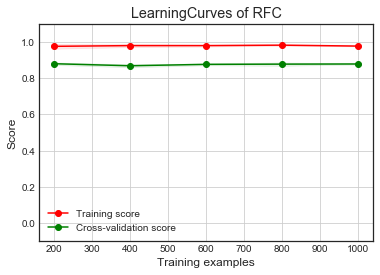

In [34]:
plot_curve(KNeighborsClassifier(n_neighbors=20), train_d, train_lab, "KNN")
plot_curve(DecisionTreeClassifier(), train_d, train_lab, "DT")
plot_curve(RandomForestClassifier(n_estimators=10), train_d, train_lab, "RFC")

<a id="ch8"></a>
## 8. Conclusion

The accuracy stays below our baseline even after tuning with hyperparameters. And the learning curves of models show that the lines of training score and validation score are paralleled, which means that adding more data won't help solve the problem.

This is an indication that there is probably no connection between the features and the class. The correlation of features plot in the exploratory analysis also suggests that the correlations are not strong between the labeled class and the features. Despite our normal impression of certain jobs with higher levels of pressure, the connection between work pressure and mental health problems is not as strong as we expected.

It could be because that people make adjustments according to their own situation. Those who are unable to deal with the pressure of their current job will leave and find other places where they are happy with. While those who stay are people who can thrive under such pressure.

Therefore, this paper is not opposed to the previous studies of relations between work pressure and mental health problems. Psychological problems such as work stress and people's reaction to it are sophisticated and complexed. Sometimes we need to be careful about what we can conclude through our quantitative analysis.

<a id="ch90"></a>

## Reference

3.5. Validation curves: plotting scores to evaluate models — scikit-learn 0.19.1 documentation [WWW Document], n.d. URL http://scikit-learn.org/stable/modules/learning_curve.html (accessed 4.23.18).

Akinfaderin, W., 2017. Missing Data Conundrum: Exploration and Imputation Techniques. Medium.

Brownlee, J., 2017. How to Handle Missing Data with Python. Machine Learning Mastery.

Discover - Quarterly Labour Force Survey, January - March, 2017 [WWW Document], n.d. URL https://discover.ukdataservice.ac.uk/catalogue?sn=8195 (accessed 4.19.18).

Guide to Encoding Categorical Values in Python - Practical Business Python [WWW Document], n.d. URL http://pbpython.com/categorical-encoding.html (accessed 4.22.18).

Harnois, G., Gabriel, P., World Health Organization, Noncommunicable Disease and Mental Health Cluster, InFocus Programme on Skills, K. and E., 2000. Mental health and work: impact, issues and good practices. World Health Organization, Geneva.

Rubinsteyn, A., 2018. fancyimpute: Multivariate imputation and matrix completion algorithms implemented in Python.

svm - Low classification accuracy, what to do next? - Cross Validated [WWW Document], n.d. URL https://stats.stackexchange.com/questions/38218/low-classification-accuracy-what-to-do-next (accessed 4.22.18).

Why accuracy alone is a bad measure for classification tasks, and what we can do about it | Tryolabs Blog [WWW Document], n.d. URL https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/ (accessed 4.21.18).




<a id="ch91"></a>
## Credits

This notebook is inspired by the following works:
- [A Data Science Framework: To Achieve 99% Accuracy
](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)
- [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)
- [Head Start for Data Scientist](https://www.kaggle.com/hiteshp/head-start-for-data-scientist/notebook)

<a id="ch92"></a>
## Versions of Libraries

In [221]:
import sys
import sklearn as skl

print("Python version:{}".format(sys.version))
print("Pandas version:{}".format(pd.__version__))
print("Numpy version:{}".format(np.__version__))
print("Matplotlib version:{}".format(mpl.__version__))
print("Seaborn version:{}".format(sns.__version__))
print("Sklearn version:{}".format(skl.__version__))
print("Fancyimpute version:0.3.1")

Python version:3.6.2 (v3.6.2:5fd33b5, Jul  8 2017, 04:57:36) [MSC v.1900 64 bit (AMD64)]
Pandas version:0.22.0
Numpy version:1.14.2
Matplotlib version:2.2.2
Seaborn version:0.8.1
Sklearn version:0.19.1
Fancyimpute version:0.3.1


<a id="ch93"></a>
## Appendix - Variable Details(LFS)

SEX- Sex of respondent
(1) Male
(2) Female

AGE- Age of respondent
(0-99) Age of respondent

STAT - Employment status 
(1) Employee 
(2) Self-employed 
(3) Government scheme 
(4) Unpaid family worker 

INDE07M – Industry sectors in main job 
(1) A - Agriculture, forestry and fishing 
(2) B,D,E - Energy and water 
(3) C -Manufacturing 
(4) F - Construction 
(5) G,I -Distribution, hotels and restaurants 
(6) H,J -Transport and communication 
(7) K,L,M,N - Banking and finance 
(8) O,P,Q - Public admin, education and health 
(9) R,S,T,U - Other services 

SC10MMJ - Major occupation group (main job) 
1 ‘Managers, Directors And Senior Officials’ 
2 ‘Professional Occupations’ 
3 ‘Associate Professional And Technical Occupations’ 
4 ‘Administrative And Secretarial Occupations’ 
5 ‘Skilled Trades Occupations’ 
6 ‘Caring, Leisure And Other Service Occupations’ 
7 ‘Sales And Customer Service Occupations’ 
8 ‘Process, Plant And Machine Operatives’ 
9 ‘Elementary Occupations’. 

TOTUS2 - Usual hours worked including overtime 
(0-96) Hours of work 
(97) 97 and over 
(99) Don’t know/No answer 

SHFTYP - Type of shift pattern 
(1) Three-shift working 
(2) Continental shifts 
(3) Two-shift system with “earlies” and “lates”/double day shifts 
(4) Sometimes night and sometimes day shifts 
(5) Split shifts 
(6) Morning shifts 
(7) Evening or twilight shifts 
(8) Night shifts 
(9) Weekend shifts 
(10) Other type of shift work 

GRSSWK - Gross weekly pay in main job 
Amount (￡)
